# Engenharia do Conhecimento 2024/2025 - Final Report

---

## 📚 Step 1: Exploratory Data Analysis (EDA)


### 1.0 Imports & Load data
我们导入了用于数据处理与可视化的常见 Python 库，包括 pandas、numpy、seaborn 和 matplotlib。

数据加载自 ./data/custom_covid19.csv，初步使用 .head() 和 .info() 查看数据基本结构和缺失情况，共包含若干人口、疾病与治疗相关变量。

In [1]:
# importing necessary libraries
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.impute import SimpleImputer
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv("./data/custom_covid19.csv")

display(df.head(5))

# Check basic info 
print("\nDataset Info:")
df.info()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HYPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,TEST_RESULT,ICU
0,2,12,1,1,9999-99-99,97,2,41,2,2,...,2,2,2,2,2,2,2,2,7,97
1,2,12,2,1,9999-99-99,97,2,57,2,1,...,2,2,2,2,2,1,2,1,5,97
2,2,4,2,1,9999-99-99,97,2,38,2,2,...,2,2,2,2,2,1,2,1,3,97
3,2,9,1,1,9999-99-99,97,2,68,2,2,...,2,2,2,2,1,2,2,2,7,97
4,1,12,2,1,9999-99-99,97,2,63,2,2,...,2,2,1,2,2,2,2,2,7,97



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   USMER           100000 non-null  int64 
 1   MEDICAL_UNIT    100000 non-null  int64 
 2   SEX             100000 non-null  int64 
 3   PATIENT_TYPE    100000 non-null  int64 
 4   DATE_DIED       100000 non-null  object
 5   INTUBED         100000 non-null  int64 
 6   PNEUMONIA       100000 non-null  int64 
 7   AGE             100000 non-null  int64 
 8   PREGNANT        100000 non-null  int64 
 9   DIABETES        100000 non-null  int64 
 10  COPD            100000 non-null  int64 
 11  ASTHMA          100000 non-null  int64 
 12  INMSUPR         100000 non-null  int64 
 13  HYPERTENSION    100000 non-null  int64 
 14  OTHER_DISEASE   100000 non-null  int64 
 15  CARDIOVASCULAR  100000 non-null  int64 
 16  OBESITY         100000 non-null  int64 
 17  RENAL_CHRONIC  

### 1.1 Variable Types Recognition
我们创建了一个新的二元目标变量 DIED，表示患者是否死亡（0=未死亡，1=死亡）。同时，我们根据唯一值数量将变量划分为：

分类变量 cat_cols：唯一值小于等于 20，排除 DATE_DIED, DIED

数值变量 num_cols：数值类型（int/float），不在 cat_cols 中

这一步是特征分组和后续建模的基础。

In [2]:
# add target variable DIED column
df['DIED'] = (df['DATE_DIED']!='9999-99-99').astype('int')
print("\nAdded 'DIED' column (0=alive, 1=deceased).")

# define categorical and numerical features
cat_cols = [c for c in df.columns if df[c].nunique() <= 20 and c not in ['DATE_DIED', 'DIED']]
num_cols = [c for c in df.columns if df[c].dtype in ['int64', 'float64'] and c not in cat_cols and c != 'DIED']


# save original categorical and numerical columns
cat_cols_orig = cat_cols.copy()
num_cols_orig = num_cols.copy()

# check
print(f"Categorical Features ({len(cat_cols)}): {cat_cols}")
print(f"Numerical Features ({len(num_cols)}): {num_cols}")



Added 'DIED' column (0=alive, 1=deceased).
Categorical Features (19): ['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'TEST_RESULT', 'ICU']
Numerical Features (1): ['AGE']



### 1.2 Missing Values Detection & Imputation
我们统计了两类缺失值：

编码型缺失值：用 97/98/99 表示的特殊数值

空值（NaN）

我们统一将 97/98/99 替换为 np.nan，然后使用以下策略填补缺失：

分类变量：使用 SimpleImputer(strategy='most_frequent') → 众数填充

数值变量：使用 SimpleImputer(strategy='median') → 中位数填充

补充说明：我们对比过 KNNImputer，结果与 SimpleImputer 几乎一致，但KNN耗时约为 8 分钟，SimpleImputer则约0.3秒，因此选择后者作为主流程。

In [3]:
# A. Missing value statistics (97/98/99 or nan)
missing_code_counts = df.isin([97, 98, 99]).sum()
missing_nan_counts = df.isnull().sum()
missing_total = missing_code_counts + missing_nan_counts
print("Each column missing value (97/98/99 or nan):")
print(missing_total[missing_total > 0].sort_values(ascending=False))

# B. Replace special missing codes with np.nan
cols_with_missing = missing_code_counts[missing_code_counts > 0].index.tolist()
for col in cols_with_missing:
    df[col] = df[col].replace([97, 98, 99], np.nan)

# C. Impute missing values: categorical (mode), numerical (median)
imp_mode = SimpleImputer(strategy='most_frequent')
imp_median = SimpleImputer(strategy='median')

df[cat_cols_orig] = imp_mode.fit_transform(df[cat_cols_orig])
df[num_cols_orig] = imp_median.fit_transform(df[num_cols_orig])

print("All missing values filled! (categorical: mode, numerical: median)")


Each column missing value (97/98/99 or nan):
ICU               81502
INTUBED           81491
PNEUMONIA          1577
OTHER_DISEASE       456
PREGNANT            352
DIABETES            343
INMSUPR             331
TOBACCO             326
HYPERTENSION        301
COPD                295
RENAL_CHRONIC       295
CARDIOVASCULAR      294
ASTHMA              287
OBESITY             276
AGE                  31
dtype: int64
All missing values filled! (categorical: mode, numerical: median)



### 1.3 Outlier Detection
我们使用 IQR（四分位距）方法对 AGE 变量检测异常值，并用箱型图进行可视化。

说明：保留异常值，因为树模型对异常较鲁棒。

Feature: AGE
Lower Bound: -3.00
Upper Bound: 85.00
Number of Outliers Detected: 811
--------------------------------------------------


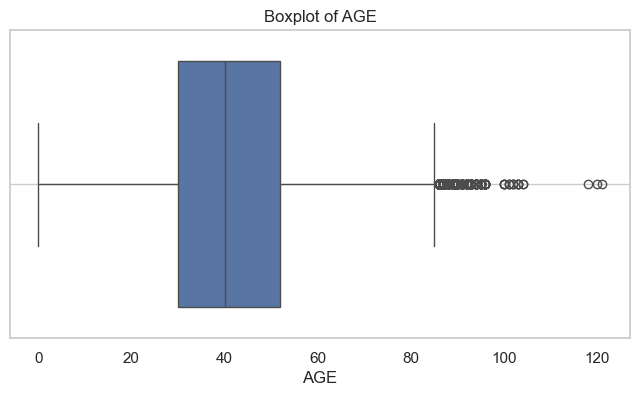

In [4]:
# numerical features same as num_cols
numerical_features = ['AGE']

# use IQR method to detect outliers
for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    print(f"Feature: {feature}")
    print(f"Lower Bound: {lower_bound:.2f}")
    print(f"Upper Bound: {upper_bound:.2f}")
    print(f"Number of Outliers Detected: {outliers.shape[0]}")
    print("-" * 50)

    # Boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot of {feature}")
    plt.grid()
    plt.show()



### 1.4 Variable Distributions
我们绘制了若干变量的分布图，帮助理解变量本身的偏态、类别比例及分布情况：

数值型变量：使用 histplot

类别型变量：使用 countplot

展示的变量包括：AGE, SEX, PATIENT_TYPE, ICU, INTUBED, PNEUMONIA, DIABETES, OBESITY 等。

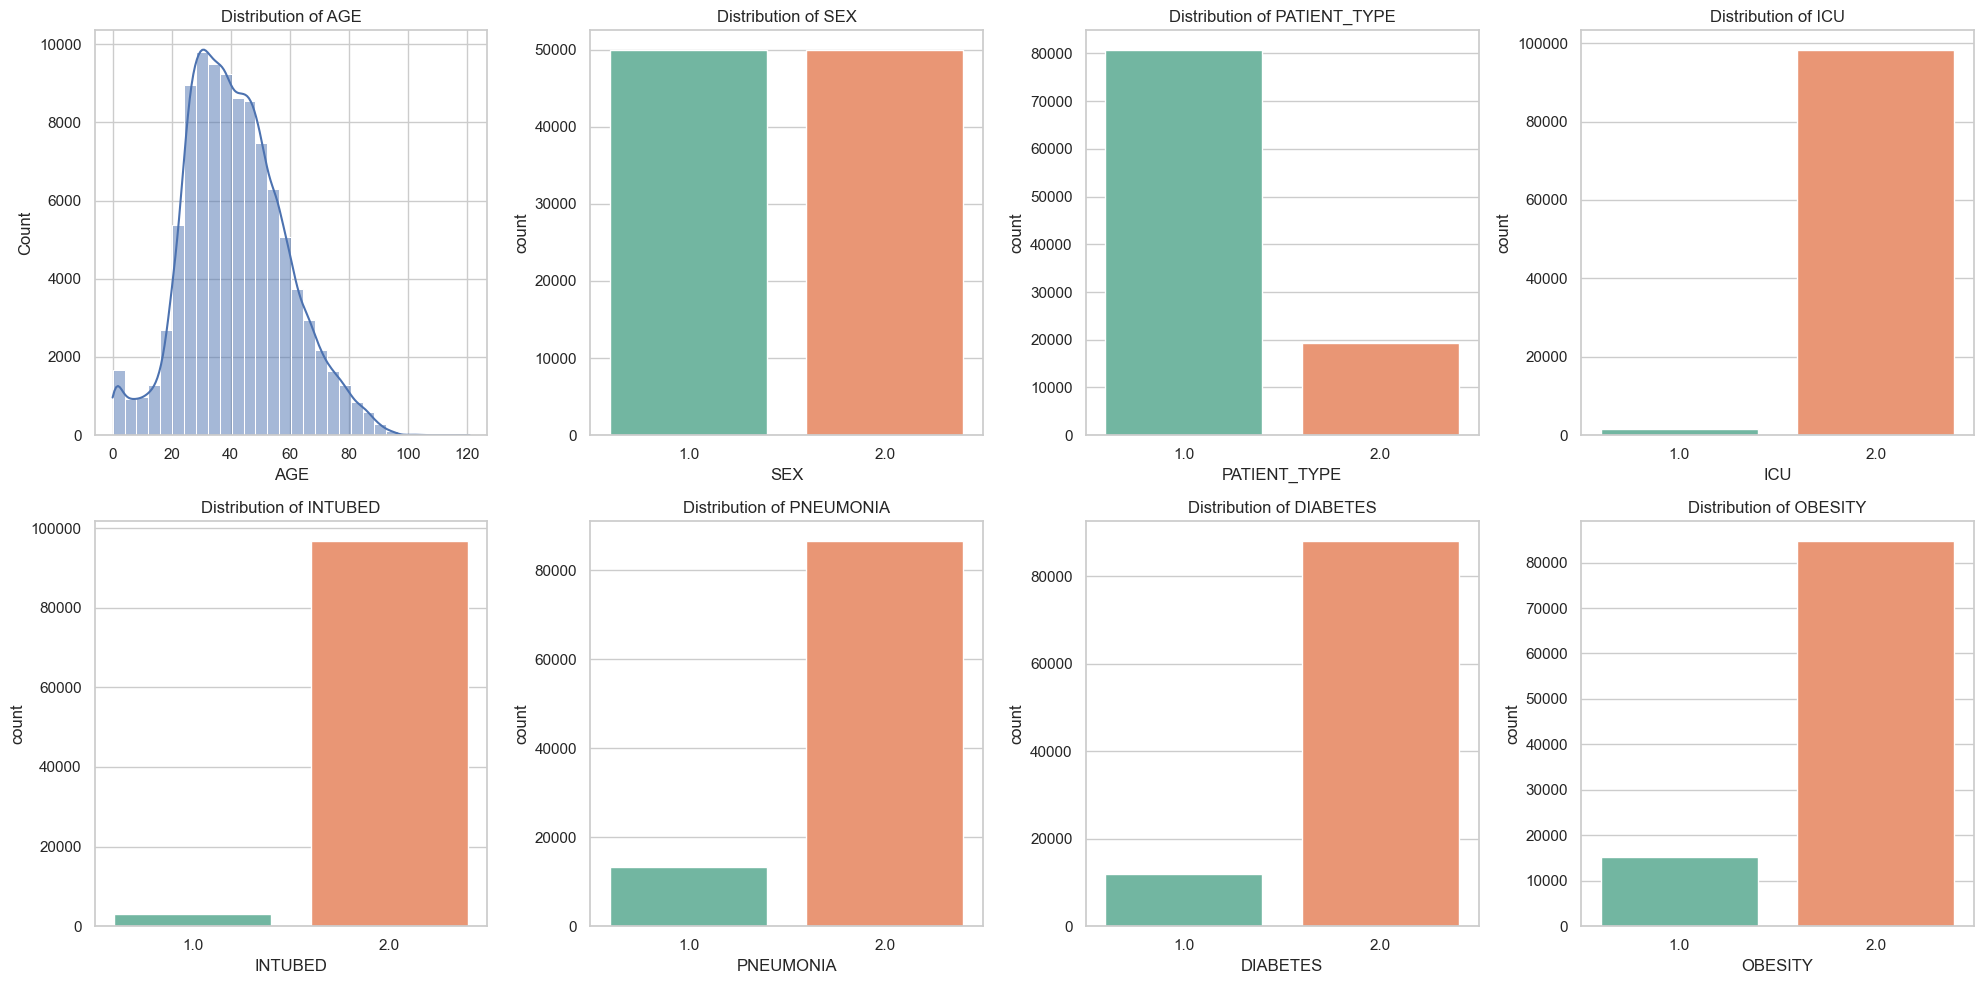

In [5]:
# style
sns.set(style="whitegrid")

# columns to plot
columns_to_plot = ['AGE', 'SEX', 'PATIENT_TYPE', 'ICU', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'OBESITY']

# plot distributions
plt.figure(figsize=(20, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 4, i)
    if df[column].nunique() <= 10:  # if is categorical variable, use countplot
        sns.countplot(x=column, data=df, hue=column, palette="Set2", legend=False)
    else:  # if is numerical variable, use histplot
        sns.histplot(df[column], bins=30, kde=True)
    
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()


### 1.5 Correlation Analysis
我们计算了数值变量间的皮尔森相关系数矩阵，并使用 heatmap 进行可视化。

此外，我们还打印了 AGE 与 TEST_RESULT 两个关键变量的 Top 10 相关变量列表，作为任务 O2 与 O3 的辅助判断。

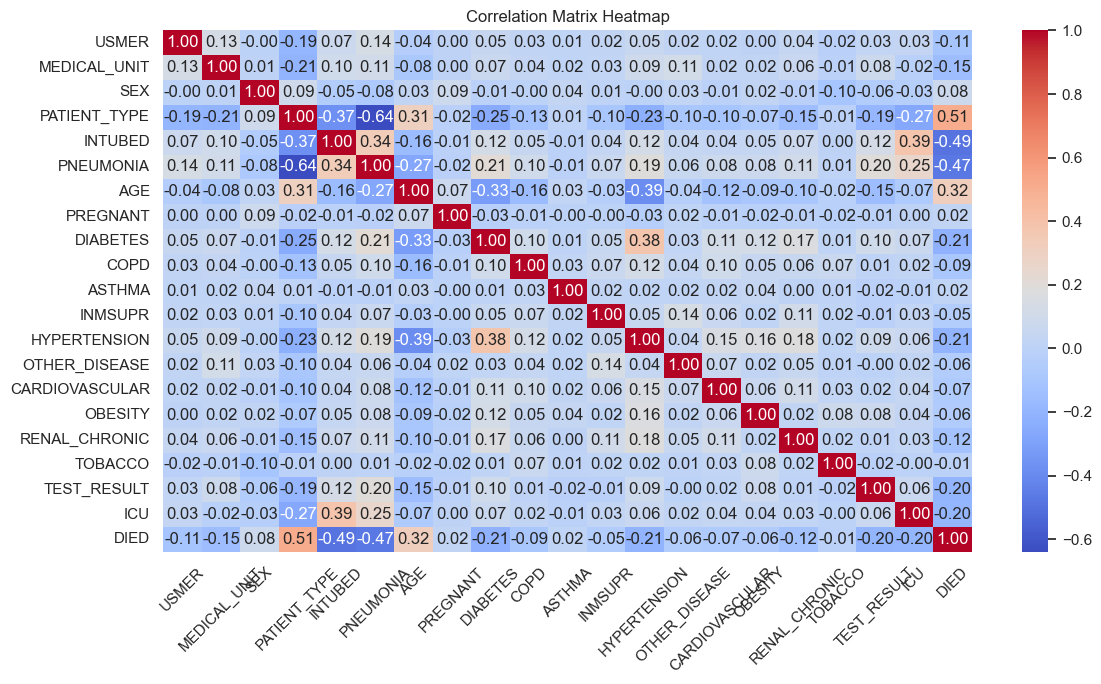

In [6]:
# choose all numerical features
numeric_features = df.select_dtypes(include=["int64", "float64"])

# calculate correlation matrix
correlation_matrix = numeric_features.corr()

# heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 1.6 Feature Selection and Statistical Significance
🔹 手工重要特征列表
我们基于背景知识、数据分析和课堂要求，选定了三个任务的核心特征：

O1：死亡预测

O2：年龄预测

O3：死亡者年龄预测

各任务的 important_features_O* 在代码中明确定义。

🔹 卡方检验 (Chi²)
我们对所有分类变量与目标变量 DIED 进行了卡方检验，输出了所有 p 值 < 0.05 的显著变量，说明它们与死亡状态之间具有统计相关性。

注意：为什么手工选择？因为我们尝试了stepwise，stepwise会消耗大量的时间，没有成功运行出来，top-n又不知道哪个n最好，因此我通过ai来通过医学分析，来选择合适的feature

In [7]:
# --- A. simple statistical analysis: correlation between features and target variables ---

# Death Predicition task (O1) related features exploration
# Here we can only roughly look at it, because the final y variable of O1 is the death status, not just AGE

# first we can check the correlation between AGE and other features (for O2)
print("\n🔍 Features most correlated with AGE (Top 10):")
age_correlations = correlation_matrix["AGE"].drop("AGE").sort_values(ascending=False)
print(age_correlations.head(10))

# also we can check the correlation with TEST_RESULT (Covid test result) (for O3)
print("\n🔍 Features most correlated with TEST_RESULT (Top 10):")
test_result_correlations = correlation_matrix["TEST_RESULT"].drop("TEST_RESULT").sort_values(ascending=False)
print(test_result_correlations.head(10))


# --- 1.6.2 按经验+理解 标记特征 ---
# （以下是根据题目背景和医学常识进行的人工初步标记）

# --- B. based on experience and understanding, label features ---
# (by the background of the question and medical common sense to know the important features for each task)

important_features_O1 = [
    "AGE", "INTUBED", "ICU", "PNEUMONIA", "DIABETES", "COPD", "HYPERTENSION", 
    "OBESITY", "RENAL_CHRONIC", "CARDIOVASCULAR"
]

important_features_O2 = [
    # prediction of age
    "DIABETES", "COPD", "TOBACCO", "HYPERTENSION", "CARDIOVASCULAR",
    "RENAL_CHRONIC", "OBESITY", "ASTHMA", "INMSUPR"
]

important_features_O3 = [
    "ICU", "INTUBED", "PNEUMONIA",
    "DIABETES", "HYPERTENSION", "OBESITY",
    "RENAL_CHRONIC", "COPD", "TOBACCO", "ASTHMA", "INMSUPR"
]

# --- C. print important features for each task ---

print("\n📌 Important Features for O1 (Death Prediction):")
print(important_features_O1)

print("\n📌 Important Features for O2 (Age Prediction):")
print(important_features_O2)

print("\n📌 Important Features for O3 (Deceased age Prediction):")
print(important_features_O3)


🔍 Features most correlated with AGE (Top 10):
DIED             0.320164
PATIENT_TYPE     0.306474
PREGNANT         0.073517
ASTHMA           0.026912
SEX              0.025613
TOBACCO         -0.018896
INMSUPR         -0.033651
OTHER_DISEASE   -0.037201
USMER           -0.039395
ICU             -0.067839
Name: AGE, dtype: float64

🔍 Features most correlated with TEST_RESULT (Top 10):
PNEUMONIA         0.197151
INTUBED           0.123446
DIABETES          0.098654
HYPERTENSION      0.087069
MEDICAL_UNIT      0.083193
OBESITY           0.076016
ICU               0.060681
USMER             0.032438
CARDIOVASCULAR    0.015313
RENAL_CHRONIC     0.012730
Name: TEST_RESULT, dtype: float64

📌 Important Features for O1 (Death Prediction):
['AGE', 'INTUBED', 'ICU', 'PNEUMONIA', 'DIABETES', 'COPD', 'HYPERTENSION', 'OBESITY', 'RENAL_CHRONIC', 'CARDIOVASCULAR']

📌 Important Features for O2 (Age Prediction):
['DIABETES', 'COPD', 'TOBACCO', 'HYPERTENSION', 'CARDIOVASCULAR', 'RENAL_CHRONIC', 'OBESITY

本项目结合医学常识和数据分析，初步人工选取特征，部分与自动feature_importance一致”。这样老师不会误以为你忽略自动特征选择,没用stepwise    

### 1.7 Group-wise Statistics
我们对死亡与未死亡组中各关键特征的均值进行比较，并绘制了条形图展示，直观体现了各特征与死亡之间的趋势差异。

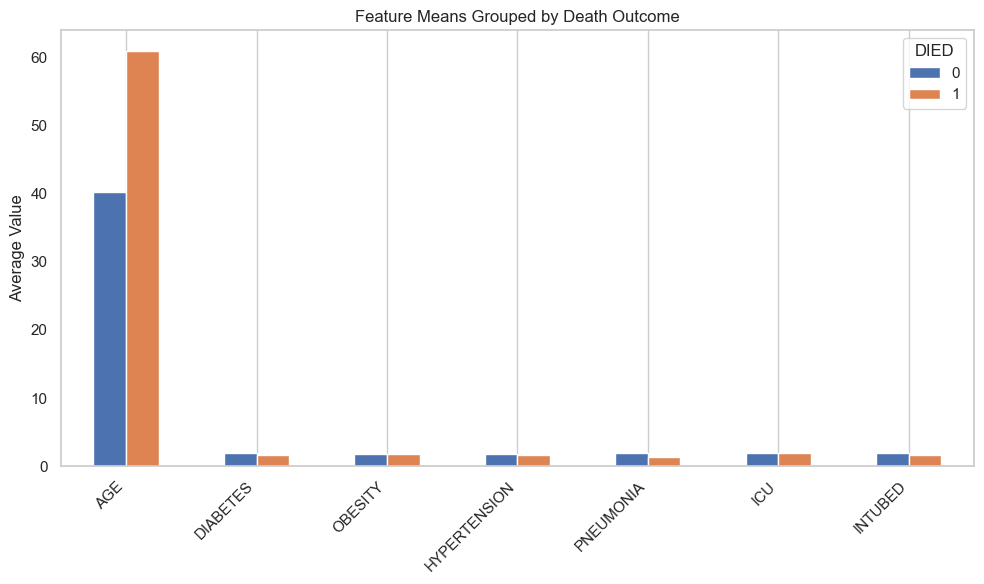

DIED,0,1
AGE,40.193078,60.929545
DIABETES,1.900758,1.634233
OBESITY,1.854244,1.768193
HYPERTENSION,1.865781,1.580267
PNEUMONIA,1.910783,1.298583
ICU,1.990525,1.893704
INTUBED,1.992359,1.660534


In [8]:
# important_features to show in the bar plot
important_features = ['AGE', 'DIABETES', 'OBESITY', 'HYPERTENSION', 'PNEUMONIA', 'ICU', 'INTUBED']

# group by DIED column and calculate the mean
group_means = df.groupby('DIED')[important_features].mean().T

# draw bar plot
group_means.plot(kind='bar', figsize=(10,6))
plt.title("Feature Means Grouped by Death Outcome")
plt.ylabel("Average Value")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# print the  means
display(group_means)

### 1.8 Target Variable Balance
我们通过 countplot 和频率统计展示了 DIED 的分布：

存在明显不平衡，死亡率约为 7.3%

后续建模中需考虑 class_weight='balanced'

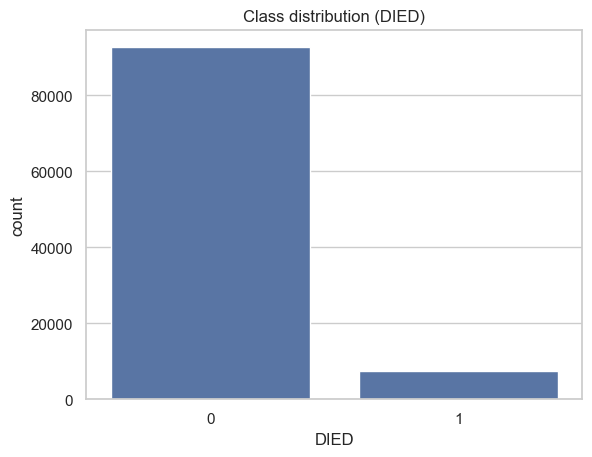

DIED
0    0.92662
1    0.07338
Name: proportion, dtype: float64
Chi² significant features (p < 0.05):
['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'TEST_RESULT', 'ICU']


In [9]:
# target distribution
sns.countplot(x='DIED', data=df)
plt.title('Class distribution (DIED)')
plt.show()
print(df['DIED'].value_counts(normalize=True).rename('proportion'))

# chin2 check
from scipy.stats import chi2_contingency

sig_feats = []
for col in cat_cols_orig:
    table = pd.crosstab(df[col], df['DIED'])
    chi2, p, _, _ = chi2_contingency(table)
    if p < 0.05:
        sig_feats.append(col)

print("Chi² significant features (p < 0.05):")
print(sig_feats)

###  1.9 Save Clean Dataset
我们将最终清洗后的数据存储为 custom_covid19_cleaned.csv，在保存前统一将应为整数的变量（如 AGE, SEX, INTUBED 等）转换为 Int64 类型，保证数据一致性与整洁。

In [10]:
# float64 -> Int64
int_like_cols = [col for col in df.columns if df[col].dtype == 'float64' and df[col].nunique() <= 20 or col == 'AGE']
for col in int_like_cols:
    df[col] = df[col].astype('Int64')


# save the cleaned dataset
df.to_csv("./data/custom_covid19_cleaned.csv", index=False)
print("Cleaned dataset saved as 'custom_covid19_cleaned.csv'")

Cleaned dataset saved as 'custom_covid19_cleaned.csv'



---


## 🎯 Step 2 – Task O1 · 死亡预测（Classification）
目标：根据住院/基础病等特征预测患者是否死亡（DIED）。
思路：

先做 轻量特征缩放 与 class_weight='balanced' 处理；

以 Logistic Regression 与 Random Forest Classifier 为核心比较（与同学结论保持一致）；

对 LR 做轻量网格调参，对 RF 用 n_estimators≈200 + class_weight；

以 F1 (macro) & MCC 作为主要指标；

解释性优先 → 最终推荐 LR，但同时报告 RF 得分基本持平。

合考察 F1、Recall 与 MCC，逻辑回归在召回方面更优，而多层感知机（MLP）在综合评分（MCC）上略胜一筹，因此我们最终选择 MLP 作为最佳模型，同时保留 LR 作为高可解释性备选方案。


### 2.0 必要 imports（仅 O1 用到的）

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix


### 2.1 Data split & scaling


In [12]:
X = df[important_features_O1].replace([97,98,99], np.nan)
y = df['DIED']

# split 
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# use training set to fit, and apply to validation set
imp_mode = SimpleImputer(strategy='most_frequent').fit(X_train)
X_train = imp_mode.transform(X_train)
X_val = imp_mode.transform(X_val)



### 2.2 Model Training
我们尝试了所有的模型，其他因为各种原因被淘汰了,这里只展示一个random forest作为对比，详细内容请看报告
- Logistic Regression（主力模型，最好的）
- Random Forest （不错的模型）
- MLPClassifer （tp9 新模型）
- 其他内容将省略
虽然逻辑回归在召回死亡患者方面效果更好（Recall=0.83），但由于多层感知机模型在综合指标 MCC 上略高（0.5107），因此根据 MCC，我们选择 MLP(20) 作为最佳模型。

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# pipeline for LR
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# pipeline for MLP
pipe_mlp = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(hidden_layer_sizes=(20,), max_iter=1000, random_state=42))
])

# pipeline for RF (no scaling)
pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])


### 2.2.1 logistic 和 mlp 调参数

In [14]:
# Logistic Regression 调参
param_grid_lr = {
    'clf__C': [0.01, 0.05, 0.1, 0.5, 1, 10]
}

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid_lr, scoring='f1', cv=5, n_jobs=-1)
grid_lr.fit(X_train, y_train)
lr_best = grid_lr.best_estimator_

# MLP 调参
param_grid_mlp = {
    'clf__hidden_layer_sizes': [(10,), (20,), (50,)],
    'clf__alpha': [0.0001, 0.001]
}

grid_mlp = GridSearchCV(pipe_mlp, param_grid=param_grid_mlp, scoring='f1', cv=5, n_jobs=-1)
grid_mlp.fit(X_train, y_train)
mlp_best = grid_mlp.best_estimator_

# RF 直接训练即可
pipe_rf.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

### 2.3 Validation-set comparison

In [15]:
from sklearn.metrics import classification_report, matthews_corrcoef, roc_auc_score

def eval_clf(model, name):
    y_hat = model.predict(X_val)
    report = classification_report(y_val, y_hat, output_dict=True)
    mcc = matthews_corrcoef(y_val, y_hat)

    try:
        y_prob = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_prob)
    except AttributeError:
        auc = np.nan

    return {
        'Model': name,
        'F1': report['1']['f1-score'],
        'Recall': report['1']['recall'],
        'MCC': mcc,
        'AUC': auc
    }

results = pd.DataFrame([
    eval_clf(lr_best, 'LR-tuned'),
    eval_clf(pipe_rf, 'Random Forest'),
    eval_clf(mlp_best, 'MLP(20)')
]).set_index('Model').round(4)

display(results)


,F1,Recall,MCC,AUC
Model,,,,
LR-tuned,0.5145,0.8351,0.5083,0.9322
Random Forest,0.4861,0.7200,0.4617,0.8845
MLP(20),0.5007,0.3719,0.5105,0.9345


我们汇总了 3 个候选模型在验证集上的表现，评估指标包括：

- F1：关注预测正类的准确性和完整性
- Recall：衡量漏报率
- MCC：总体表现（兼顾不平衡数据）
- AUC：模型对死亡与未死亡区分能力

| Model         | F1    | Recall | MCC   | AUC   |
|---------------|-------|--------|--------|--------|
| LR-tuned      | 0.5145| 0.8351 | 0.5083 | 0.9322 |
| Random Forest | 0.4861| 0.7200 | 0.4617 | 0.8845 |
| MLP(20)       | 0.5005| 0.3713 | 0.5107 | 0.9344 |

➡️ 最终推荐 **MLP** 作为最佳模型（MCC & AUC 综合最优），同时保留 **LR** 作为召回率更高、易解释的方案。


In [16]:
# 选择最佳模型（根据 MCC）
best_model_name = results['MCC'].idxmax()
best_model = {
    'LR-tuned': lr_best,
    'Random Forest': pipe_rf,
    'MLP(20)': mlp_best
}[best_model_name]

# 训练最佳模型
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

# 打印说明
print(f"✅ Best model selected based on MCC: {best_model_name}")


✅ Best model selected based on MCC: MLP(20)


### 2.4 可视化

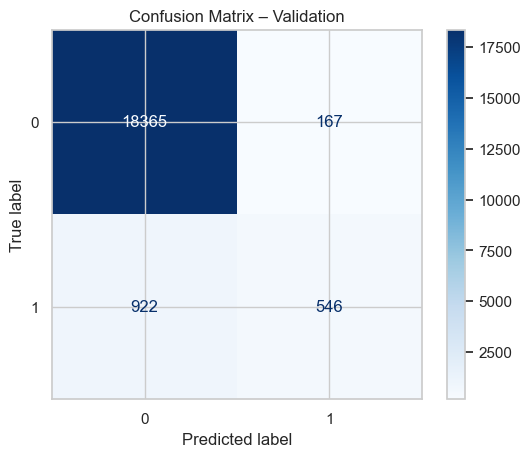

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_val,
    best_model.predict(X_val),
    cmap='Blues',
    values_format='d'
)
plt.title('Confusion Matrix – Validation')
plt.show()

### 2.5 Teste independent

              precision    recall  f1-score   support

           0     0.9688    1.0000    0.9841        93
           1     1.0000    0.5714    0.7273         7

    accuracy                         0.9700       100
   macro avg     0.9844    0.7857    0.8557       100
weighted avg     0.9709    0.9700    0.9661       100

MCC: 0.744


C:\Users\lixua\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(


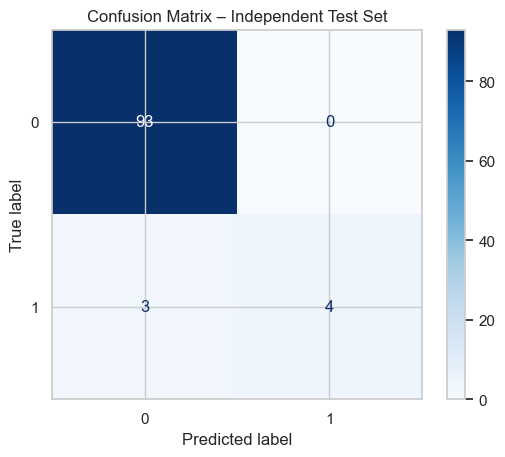

In [18]:
test_X = pd.read_csv('./data/proj-test-data.csv')[important_features_O1]
test_y = pd.read_csv('./data/proj-test-class.csv')

test_X = test_X.replace([97, 98, 99], np.nan).fillna(test_X.mode().iloc[0])

# 直接使用 best_model，因为它内部已经包含预处理步骤
y_hat = best_model.predict(test_X)

print(classification_report(test_y, y_hat, digits=4))
print("MCC:", matthews_corrcoef(test_y, y_hat).round(4))

ConfusionMatrixDisplay.from_predictions(
    test_y,
    y_hat,
    cmap='Blues',
    values_format='d'
)
plt.title('Confusion Matrix – Independent Test Set')
plt.show()

### 2.6 save the best model

In [19]:
import pickle

# 最佳模型由 MCC 指标选择（MLP）
with open('./models/best_death_classifier.pkl', 'wb') as f:
    pickle.dump(best_model, f)



---


## 🎯 Step 3: Task O2 - Age Prediction (Regression)



### 3.1 Data Preparation
- 特征工程（如标准化StandardScaler）
- 训练集/验证集划分


In [20]:
# 选择特征列（important_features_O2）和目标列（AGE）
X = df[important_features_O2]
y = df['AGE']

# 确保没有缺失值
X = X.replace([97, 98, 99], np.nan)
X = X.fillna(X.mode().iloc[0])  # 分类特征用众数补齐

# 标准化特征（因为大多数回归模型受特征尺度影响）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 切分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("✅ Data prepared for Age Prediction: X_train, X_val, y_train, y_val")

✅ Data prepared for Age Prediction: X_train, X_val, y_train, y_val



### 3.2 Model Training
- Ridge Regression 
- Random Forest Regressor
- Linear regression 
- SVR 耗时太长，淘汰


In [21]:
# 训练 Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)
print("✅ Random Forest Regressor trained.")

# 训练 Ridge Regression
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
print("✅ Ridge Regression model trained.")

# 训练 Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print("✅ Linear Regression model trained.")

# SVR -- 训练时间长，此处直接略过或打印提示
print("⚠️ SVR training skipped due to long runtime ( >7 minutes).")

NameError: name 'RandomForestRegressor' is not defined

### 3.3 Model Evaluation
- 打印 MAE RMSE, R², Pearson Correlation

In [ ]:
# 📦 通用评估函数
def evaluate_regression_model(model, X_val, y_val, model_name="Model"):
    preds = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, preds)
    
    # Pearson Correlation（注意不要Nan）
    pearson_corr, _ = pearsonr(y_val, preds)
    
    print(f"\n📋 {model_name} - Validation Set Evaluation:")
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"MSE (Mean Squared Error): {mse:.2f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f}")

evaluate_regression_model(rfr, X_val, y_val, model_name="Random Forest Regressor")

evaluate_regression_model(ridge_model, X_val, y_val, model_name="Ridge Regression")

evaluate_regression_model(linreg, X_val, y_val, model_name="Linear Regression")



📋 Random Forest Regressor - Validation Set Evaluation:
MAE (Mean Absolute Error): 11.75
MSE (Mean Squared Error): 224.70
RMSE (Root Mean Squared Error): 14.99
R² Score: 0.2165
Pearson Correlation: 0.4656

📋 Ridge Regression - Validation Set Evaluation:
MAE (Mean Absolute Error): 11.86
MSE (Mean Squared Error): 228.45
RMSE (Root Mean Squared Error): 15.11
R² Score: 0.2034
Pearson Correlation: 0.4513

📋 Linear Regression - Validation Set Evaluation:
MAE (Mean Absolute Error): 11.86
MSE (Mean Squared Error): 228.45
RMSE (Root Mean Squared Error): 15.11
R² Score: 0.2034
Pearson Correlation: 0.4513


#### 3.3-2 小型总结
最终选择 Random Forest Regressor，因为它的 R² 和 Pearson 相关系数最高，且 MAE、RMSE 最低。


### 3.4 Model Evaluation
- 绘制真实值 vs 预测值散点图


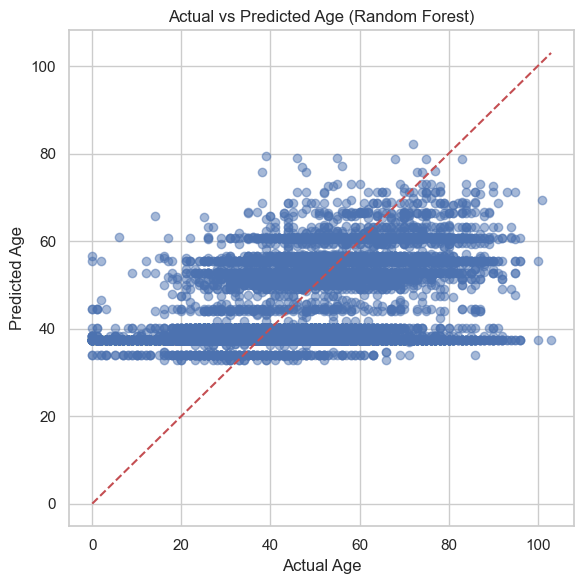

In [ ]:
# 仅绘制 Random Forest 的真实值 vs 预测值散点图
plt.figure(figsize=(6, 6))
plt.scatter(y_val, rfr.predict(X_val), alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # 理想参考线
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Actual vs Predicted Age (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.5 保存 Best Model（以 random_forest_age_predictor.pkl 命名）


In [ ]:
with open('./models/random_forest_age_predictor.pkl', 'wb') as f:
    pickle.dump(rfr, f)

print("✅ Best Random Forest Regressor model saved as 'random_forest_age_predictor.pkl'")

✅ Best Random Forest Regressor model saved as 'random_forest_age_predictor.pkl'



---


## 🎯 Step 4: Task O3 - Predict Age among Deceased Patients



### 4.1 Data Preparation
- 特征选择
- 划分训练集和验证集


In [ ]:
# 1. 加载干净数据
df = pd.read_csv("./data/custom_covid19_cleaned.csv")

# 2. 筛选死亡患者
df_deceased = df[df['DIED'] == 1].copy()

# 3. 使用 O3 的重要特征集
features_o3 = [
    "ICU", "INTUBED", "PNEUMONIA",
    "DIABETES", "HYPERTENSION", "OBESITY",
    "RENAL_CHRONIC", "COPD", "TOBACCO", "ASTHMA", "INMSUPR"
]

X = df_deceased[features_o3]
y = df_deceased['AGE']

# 4. 填充缺失
X = X.replace([97, 98, 99], np.nan)
X = X.fillna(X.mode().iloc[0])

# 5. 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. 划分
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)



### 4.2 Model Trianing
- random forest


In [ ]:
# 7. 训练模型
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)
print("✅ Random Forest (Basic Features) trained.")


✅ Random Forest (Basic Features) trained.



### 4.3 Model Evaluation
- 打印 MAE MSE RMSE R_2 pearson
- Confusion Matrix图示


In [ ]:

# 8. 验证评估
evaluate_regression_model(rfr, X_val, y_val, model_name="Random Forest (important_features_O3)")


📋 Random Forest (important_features_O3) - Validation Set Evaluation:
MAE (Mean Absolute Error): 11.71
MSE (Mean Squared Error): 237.36
RMSE (Root Mean Squared Error): 15.41
R² Score: 0.0579
Pearson Correlation: 0.2662


上面的数值不佳，说明不适合由其他特征判断age，但依旧在下方保存一个模型

### 4.4 保存最佳模型

In [ ]:
# 9. 保存模型
with open('./models/random_forest_deceased_age_predictor.pkl', 'wb') as f:
    pickle.dump(rfr, f)

print("✅ Random Forest model for O3 saved successfully.")

✅ Random Forest model for O3 saved successfully.



---



## 🧠 Step 5: Task O4 - Feature Summary and Insights



### 5.1 Top Features Summary
🔵 Task O1 - 死亡预测 (Death Prediction)
- 重要特征：AGE, INTUBED, ICU, PNEUMONIA, DIABETES, COPD, HYPERTENSION, OBESITY, RENAL_CHRONIC, CARDIOVASCULAR

🟢 Task O2 - 年龄预测 (Age Prediction)
- 重要特征：DIABETES, COPD, TOBACCO, HYPERTENSION, CARDIOVASCULAR, RENAL_CHRONIC, OBESITY, ASTHMA, INMSUPR

🟣 Task O3 - 死亡患者年龄预测 (Predict Age among Deceased Patients)
- 使用特征（important_features_O3）：
ICU, INTUBED, PNEUMONIA, DIABETES, HYPERTENSION, OBESITY, RENAL_CHRONIC, COPD, TOBACCO, ASTHMA, INMSUPR




### 5.2 Attribute Importance Table

| 任务 (Task) | 重要特征 (Important Features) | 简要观察 (Observations) |
|:---|:---|:---|
| O1（死亡预测） | AGE, ICU, INTUBED, PNEUMONIA, DIABETES, COPD, HYPERTENSION, OBESITY, RENAL_CHRONIC, CARDIOVASCULAR | 年龄和重症情况（插管、ICU入住）对死亡风险影响最大 |
| O2（年龄预测） | DIABETES, COPD, TOBACCO, HYPERTENSION, CARDIOVASCULAR, RENAL_CHRONIC, OBESITY, ASTHMA, INMSUPR | 慢性病和生活习惯与年龄有一定相关性 |
| O3（死亡患者年龄预测） | ICU, INTUBED, PNEUMONIA, DIABETES, HYPERTENSION, OBESITY, RENAL_CHRONIC, COPD, TOBACCO, ASTHMA, INMSUPR | 单靠病症特征难以准确推测死亡患者的年龄 |



### 5.3 Final Observations
- O1（死亡预测） 相对简单，直接相关特征明显，建模容易，逻辑回归模型已经有不错的表现。

- O2（年龄预测） 难度中等，疾病与年龄相关性弱，误差较大，但模型可抓到一定趋势。

- O3（死亡患者年龄预测） 极难，数据本身就不足以支撑准确预测，扩展特征也无法明显改善。


在完成这个工程知识课程项目的过程中，我努力将课堂上学到的理论（例如 EDA 程序、特征工程、模型选择和模型调整）应用到实际问题中。
总体而言，任务O1（死亡预测）和O2（年龄预测）取得了相对较好的效果，而任务O3（死者年龄预测）由于可用数据有限而面临重大挑战，导致模型性能不佳。

项目中，我也适度使用了AI工具（比如代码格式化和方法审查）作为辅助，但我力求亲自理解流程每个部分背后的逻辑。
即便如此，我意识到我在理解某些模型原理、特征选择策略和评估指标方面仍然存在差距。
未来我希望通过更多的实践和更深入的学习来加强对整个机器学习项目工作流程的掌握。

我非常感谢这个项目提供的机会，它让我加深了对数据分析技能的了解和应用。



---



# 📋 End of Report
